<a href="https://colab.research.google.com/github/clyde2020/ML_Portfolio/blob/main/Kaggle_Histopathologic_Cancer_Detection_with_Split.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import shutil
from shutil import copyfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam
import matplotlib.pyplot as plt
import random
!pip install keras-tuner -q
from keras_tuner import RandomSearch
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from glob import glob
#from sklearn.model_selection import RandomizedSearchCV

from google.colab import drive
drive.mount('/content/gdrive')

     |████████████████████████████████| 98 kB 6.4 MB/s 
Mounted at /content/gdrive


Read in the labels

In [2]:
df = pd.read_csv('/content/gdrive/MyDrive/Histopath/train_labels.csv')
print(len(df.id))

picdict = dict(zip(df['id'], df['label']))

220025


Folder creation before split data

In [ ]:
os.mkdir('/content/gdrive/MyDrive/Histopath/Thirty')
os.mkdir('/content/gdrive/MyDrive/Histopath/Thirty/Train')
os.mkdir('/content/gdrive/MyDrive/Histopath/Thirty/Valid')
os.mkdir('/content/gdrive/MyDrive/Histopath/Thirty/Train/Benign')
os.mkdir('/content/gdrive/MyDrive/Histopath/Thirty/Valid/Benign')
os.mkdir('/content/gdrive/MyDrive/Histopath/Thirty/Train/Malignant')
os.mkdir('/content/gdrive/MyDrive/Histopath/Thirty/Valid/Malignant')

Set data folder variables

In [3]:
# Update these variables according to the dataset to use
train_comp = '/content/gdrive/MyDrive/Histopath/Thirty/Train'
valid_comp = '/content/gdrive/MyDrive/Histopath/Thirty/Valid'
benign_train_comp = '/content/gdrive/MyDrive/Histopath/Thirty/Train/Benign'
benign_valid_comp = '/content/gdrive/MyDrive/Histopath/Thirty/Valid/Benign'
mal_train_comp = '/content/gdrive/MyDrive/Histopath/Thirty/Train/Malignant'
mal_valid_comp = '/content/gdrive/MyDrive/Histopath/Thirty/Valid/Malignant'

Shuffle the data and set up lists before split data

In [ ]:
source_folder = '/content/gdrive/MyDrive/Histopath/Thirty_set'
source_list = os.listdir(source_folder)

valid_number = 3000
valid_list = source_list[:valid_number]
train_list = source_list[valid_number:]

print(train_list[0:5])
print(len(train_list))

This function splits the dataset into malignant and benign

In [ ]:
def split_data(LIST, SOURCE, MAL_FOLDER, BENIGN_FOLDER):
  for fname in LIST:
    origin = os.path.join(SOURCE, fname)
    name = os.path.splitext(os.path.basename(fname))[0]
    if os.path.getsize(origin) > 1:
      if picdict[name] == 0:
        shutil.copy(origin, BENIGN_FOLDER)
      else:
        shutil.copy(origin, MAL_FOLDER)

Execute the data split

In [ ]:
split_data(valid_list, source_folder, mal_valid_comp, benign_valid_comp)
split_data(train_list, source_folder, mal_train_comp, benign_train_comp)

Confirm we have the data in the correct spot

In [5]:
print(len(os.listdir(benign_train_comp)))
print(len(os.listdir(mal_train_comp)))
print(len(os.listdir(benign_valid_comp)))
print(len(os.listdir(mal_valid_comp)))

16120
10880
1796
1204


Data Augmentation

In [6]:
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                  rotation_range=45,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_comp,
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1/255.0)  

validation_generator = validation_datagen.flow_from_directory(
    valid_comp,
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary') 

Found 27000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.


Model with LR scheduler, only for small set

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(96, 3, input_shape=(96, 96, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(160, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(256, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(256, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2),                   
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 5))
#optimizer = tf.keras.optimizers.Adam(learning_rate=1e-7)
#model.compile(loss=tf.keras.losses.Huber(),
#              optimizer=optimizer,
#              metrics=["mae"])


model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['acc'])

model.summary()

In [ ]:
history = model.fit(train_generator,
                    epochs=20,
                    verbose=1,
                    callbacks=[lr_schedule],
                    validation_data=validation_generator)

(1e-05, 0.1, 0.0, 1.0)

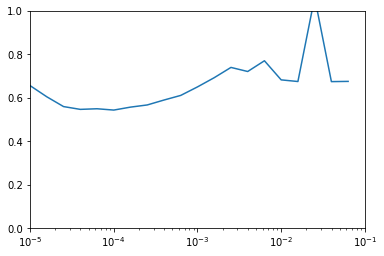

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1e-1, 0, 1])

Use Keras Tuner to get best model hyperparameters

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)

def build_model(hp):
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(filters=hp.Choice('filters1',
                             values=[96, 128, 160, 192]), 
                             kernel_size=3, 
                             input_shape=(96, 96, 3), 
                             activation='relu'),
      tf.keras.layers.MaxPooling2D(2),
      tf.keras.layers.Conv2D(filters=hp.Choice('filters2',
                             values=[160, 192, 224, 256]), 
                             kernel_size=3, activation='relu'),
      tf.keras.layers.MaxPooling2D(2),
      tf.keras.layers.Conv2D(filters=hp.Choice('filters3',
                             values=[160, 192, 224, 256, 288, 320]), 
                             kernel_size=3, activation='relu'),
      tf.keras.layers.MaxPooling2D(2),
                            
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(units=hp.Choice('units',
                            values=[800, 1000, 2000, 4000]), activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

  return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective="acc",
    max_trials=12,
    executions_per_trial=1,
    overwrite=True,
    #directory="keras_tuner_directory",
    project_name="Cancer_Detection",
)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
filters1 (Choice)
{'default': 96, 'conditions': [], 'values': [96, 128, 160, 192], 'ordered': True}
filters2 (Choice)
{'default': 160, 'conditions': [], 'values': [160, 192, 224, 256], 'ordered': True}
filters3 (Choice)
{'default': 160, 'conditions': [], 'values': [160, 192, 224, 256, 288, 320], 'ordered': True}
units (Choice)
{'default': 800, 'conditions': [], 'values': [800, 1000, 2000, 4000], 'ordered': True}


In [ ]:
tuner.search(train_generator, epochs=120, validation_data=validation_generator)

Trial 12 Complete [00h 08m 42s]
acc: 0.8580858111381531

Best acc So Far: 0.8734873533248901
Total elapsed time: 01h 50m 59s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary(6)

Results summary
Results in ./Cancer_Detection
Showing 6 best trials
Objective(name='acc', direction='max')
Trial summary
Hyperparameters:
filters1: 160
filters2: 224
filters3: 160
units: 2000
Score: 0.8734873533248901
Trial summary
Hyperparameters:
filters1: 192
filters2: 192
filters3: 160
units: 4000
Score: 0.8701870441436768
Trial summary
Hyperparameters:
filters1: 192
filters2: 160
filters3: 224
units: 4000
Score: 0.8690869212150574
Trial summary
Hyperparameters:
filters1: 192
filters2: 256
filters3: 288
units: 1000
Score: 0.8635863661766052
Trial summary
Hyperparameters:
filters1: 160
filters2: 160
filters3: 224
units: 4000
Score: 0.8635863661766052
Trial summary
Hyperparameters:
filters1: 192
filters2: 256
filters3: 256
units: 2000
Score: 0.8624862432479858


Execute best parameters

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=160, 
                            kernel_size=3, 
                            input_shape=(96, 96, 3), 
                            activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(filters=224, 
                            kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(filters=160, 
                            kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
                          
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=2000, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

es = EarlyStopping(monitor='acc', min_delta=0.003, patience=10,
                   verbose=1, mode='auto')
mc = ModelCheckpoint(monitor='acc', filepath='./bestmodel.h5', 
                     verbose=1, save_best_only=True, mode='auto')

cd = [es, mc]

In [ ]:
history = model.fit(train_generator,
                    epochs=120,
                    verbose=1,
                    validation_data=validation_generator,
                    #callbacks=cd
                    )

In [ ]:
model = load_model('/content/bestmodel.h5')

In [ ]:
h = history.history
h.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

Model results with Adam optimizer, we need to add regularization

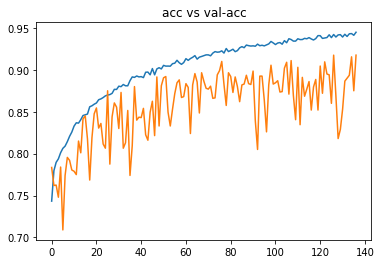

In [ ]:
plt.plot(h['acc'])
plt.plot(h['val_acc'])
plt.title('acc vs val-acc')
plt.show()

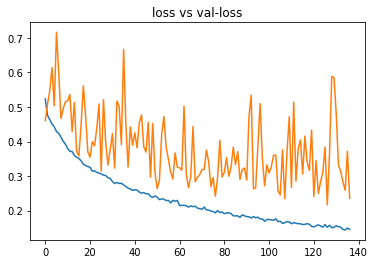

In [ ]:
plt.plot(h['loss'])
plt.plot(h['val_loss'])
plt.title('loss vs val-loss')
plt.show()

Adding regularization - Grid search performed in another notebook for best parameters

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=96, 
                            kernel_size=3, 
                            input_shape=(96, 96, 3), 
                            activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(filters=96, 
                            kernel_size=3, 
                            activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(filters=960, 
                            kernel_size=4, 
                            activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(filters=960, 
                            kernel_size=4, 
                            activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.2),  

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=800, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])


In [ ]:
history = model.fit(train_generator,
                    epochs=120,
                    verbose=1,
                    validation_data=validation_generator,
                    )

Epoch 1/120
844/844 [==============================] - 175s 195ms/step - loss: 0.5462 - acc: 0.7440 - val_loss: 0.6032 - val_acc: 0.6547
Epoch 2/120
844/844 [==============================] - 157s 186ms/step - loss: 0.4971 - acc: 0.7786 - val_loss: 1.1426 - val_acc: 0.6527
Epoch 3/120
844/844 [==============================] - 157s 186ms/step - loss: 0.4658 - acc: 0.7928 - val_loss: 0.6911 - val_acc: 0.7113
Epoch 4/120
844/844 [==============================] - 157s 186ms/step - loss: 0.3967 - acc: 0.8330 - val_loss: 0.5264 - val_acc: 0.7597
Epoch 5/120
844/844 [==============================] - 157s 186ms/step - loss: 0.3883 - acc: 0.8338 - val_loss: 0.6589 - val_acc: 0.7017
Epoch 6/120
844/844 [==============================] - 157s 186ms/step - loss: 0.3734 - acc: 0.8409 - val_loss: 0.6667 - val_acc: 0.7533
Epoch 7/120
844/844 [==============================] - 157s 186ms/step - loss: 0.3610 - acc: 0.8464 - val_loss: 0.7601 - val_acc: 0.7200
Epoch 8/120
844/844 [====================

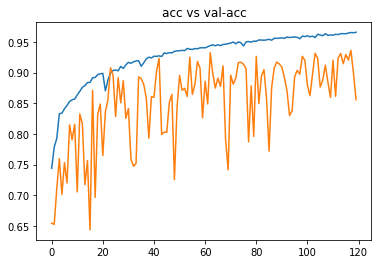

In [ ]:
h = history.history
plt.plot(h['acc'])
plt.plot(h['val_acc'])
plt.title('acc vs val-acc')
plt.show()

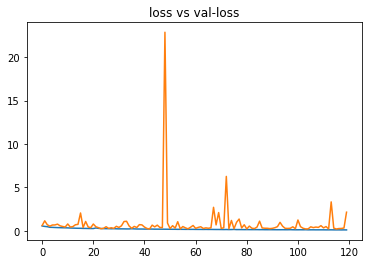

In [ ]:
plt.plot(h['loss'])
plt.plot(h['val_loss'])
plt.title('loss vs val-loss')
plt.show()

In [ ]:
plt.plot(h['loss'])
plt.plot(h['val_loss'])
plt.title('loss vs val-loss')
plt.axis([0, 120, 0, 3])
plt.show()

In [ ]:
model.save('/content/gdrive/MyDrive/Histopath/thirty_model.h5')

In [ ]:
import pickle

with open('/content/gdrive/MyDrive/Histopath/thirty_data', 'wb') as f:
  pickle.dump(history.history, f)